# NYC Taxi Data Set

In this notebook, we will be analyzing the data from September 2015 of the Taxi data set in NYC.
The sequence of the notebook is the same sequence of the Questions asked in the email.

To do this Analysis, i utilize 3 open source softwares

* Python: Used mainly for the most part of data cleaning, and modeling.
* QGIS: Used for Geospatial data
* R: For statistical Analysis(Please refer to R_analysis.html)

I spent alot of time trying to get the census data from the latitude and longitude using google api from python for reverse geoencoding but i was limited to a number of calls. so i transfered to a GIS platform, i was able to get population(zipcode level), area(zipcode level), median income(zipcode level), county, city, and zip code.

After that i exported the data to run it on the script i created in python, but some of the columns was paresed wronf(for example, date changed to YYYY/MM/DD) instead of the original format. I didn't have time to write another script to fix all the changes and the data didn't have a unique column to join on. so i decided not to use the data.

Please notice that i have taken some assumptions, for data cleaning that might change some numbers, for example the number of trips terminated at the airports before cleaning is 5500 and after cleaning is 4274 etc..

In [345]:
# Load python modules and data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import warnings
import missingno as mn
import datetime
import math
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import KFold # import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import xgboost as xgb
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
warnings.filterwarnings("ignore")

if os.path.isfile('data/Capital One.csv'):
    df = pd.read_csv('data/Capital One.csv') 
else:
    url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv'
    df = pd.read_csv(url)
df.head()

VendorID lpep_pickup_datetime Lpep_dropoff_datetime Store_and_fwd_flag  \
0         2  2015-09-01 00:02:34   2015-09-01 00:02:38                  N   
1         2  2015-09-01 00:04:20   2015-09-01 00:04:24                  N   
2         2  2015-09-01 00:01:50   2015-09-01 00:04:24                  N   
3         2  2015-09-01 00:02:36   2015-09-01 00:06:42                  N   
4         2  2015-09-01 00:00:14   2015-09-01 00:04:20                  N   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           5        -73.979485        40.684956         -73.979431   
1           5        -74.010796        40.912216         -74.010780   
2           1        -73.921410        40.766708         -73.914413   
3           1        -73.921387        40.766678         -73.931427   
4           1        -73.955482        40.714046         -73.944412   

   Dropoff_latitude  Passenger_count     ...      Fare_amount  Extra  MTA_tax  \
0         40.685020                1     ...              7.8    0.0      0.0   
1         40.912212                1     ...             45.0    0.0      0.0   
2         40.764687                1     ...              4.0    0.5      0.5   
3         40.771584                1     ...              5.0    0.5      0.5   
4         40.714729                1     ...              5.0    0.5      0.5   

   Tip_amount  Tolls_amount  Ehail_fee  improvement_surcharge  Total_amount  \
0        1.95           0.0        NaN                    0.0          9.75   
1        0.00           0.0        NaN                    0.0         45.00   
2        0.50           0.0        NaN                    0.3          5.80   
3        0.00           0.0        NaN                    0.3          6.30   
4        0.00           0.0        NaN                    0.3          6.30   

   Payment_type  Trip_type   
0             1         2.0  
1             1         2.0  
2             1         1.0  
3             2         1.0  
4             2         1.0  

[5 rows x 21 columns]

In [346]:
#check number of rows and columns
print('Number of rows in the taxi data is:', df.shape[0])
print('Number of columns in the taxi data is:', df.shape[1])

Number of rows in the taxi data is: 1494926
Number of columns in the taxi data is: 21


# Initial Cleaning
Before we jump into any analysis, i want to make sure that there is no data errors

* Trip Distance has to be greater than zero, there are some missing values in the pick up location that's wat's causing the zeros(17980 records) i decide to drop these observations
* Fare Amount, according to http://nymag.com/nymetro/urban/features/taxi/n_20286/  the initial fare increase from 2 USD to  2.5 USD on May 3rd but i couldn't find what year this article was released, and this data is from 2015, so i will be consevitaive and say that any value fot the Fair amount under 2 USD is a data error
* Passenger Count, there needs to be atleast 1 passenger to initiate a trip, so any value with less than 1 will be considered data error
* If the tip ammount more than the fare amount i will consider it as a data error
* Later on in question 5, when i compute the trip time in minutes, there are 950 records that have data error where the pick up time is equal the drop off time, so the trip time is zero, and i replace this with the median(this will be done late in the notebook)(around 900 observations)
* The trip duration has some weird entries with trips more than 7 hours, i did a bit of research and found that the longest ride that someone reported was 6 hours, i will assume that if a trip exceed 7 hours, it's a data error and i will replace it with the median(this will be done late in the notebook)(around 8000 observations)
*There was some observations with long trip distance ( > 7 miles) and the trip time for them was less than 1 minute, this is considered data error and i will compute the speed and any observation > 50 mph i will consider as data eror and remove it

In [347]:
print('Number of trips with distance less than zero is', df['Trip_distance'][df['Trip_distance'] <= 0].count())
print('Number of Fair Amount less than 2 USD is', df['Fare_amount'][df['Fare_amount'] < 2].count())
print('Number of trips with passengers less than 1 is', df['Passenger_count'][df['Passenger_count'] < 1].count())
print('Number of trips with passengers with tip amount more than fare amount is', (df['Tip_amount'][df['Tip_amount'] > df['Fare_amount']]).count())


Number of trips with distance less than zero is 20592
Number of Fair Amount less than 2 USD is 7395
Number of trips with passengers less than 1 is 440
Number of trips with passengers with tip amount more than fare amount is 4991


In [348]:
df = df[df['Trip_distance'] > 0]
df = df[df['Fare_amount'] >= 2]
df = df[df['Passenger_count'] >= 1]
df = df[df['Tip_amount'] < df['Fare_amount']]
df.shape

(1466716, 21)

Now the data is clean from data errors

In [349]:
#include=['Trip_Distance', 'Fare_amount', 'Tip_amount']
df['Trip_distance'].describe()#showing some stats on

count    1.466716e+06
mean     3.011723e+00
std      3.032681e+00
min      1.000000e-02
25%      1.110000e+00
50%      2.000000e+00
75%      3.790000e+00
max      2.462800e+02
Name: Trip_distance, dtype: float64

In [350]:
print(df['Trip_distance'].describe())

count    1.466716e+06
mean     3.011723e+00
std      3.032681e+00
min      1.000000e-02
25%      1.110000e+00
50%      2.000000e+00
75%      3.790000e+00
max      2.462800e+02
Name: Trip_distance, dtype: float64


Now let's look at the distribution

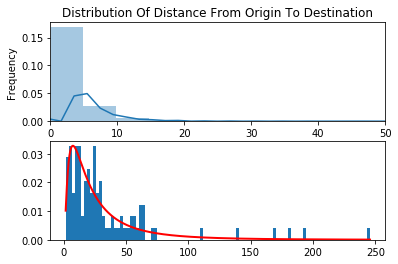

In [351]:
#plotting the new data without the outliers
plt.subplot(2,1,1)
sns.distplot(df['Trip_distance'])
plt.title('Distribution Of Distance From Origin To Destination')
plt.xlabel('Distance In Miles')
plt.ylabel('Frequency')
plt.xlim(0,50)
plt.subplot(2,1,2)
#the code for simulating a lognormal distribution is form scipy
#https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.random.lognormal.html
mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, 100)
#Display the histogram of the samples, along with the probability density function:
count, bins, ignored = plt.hist(s, 100, normed=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
        / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

we can see this distribution is right skewed, this is a better picture than the lognormal simulation i did, and i can make a hypothesis that the distribution is lognormal. It's also noticed that the mean and the median is smaller than the standard deviation.

Hypothesis is that the sidtribution follows a log normal distribution and it's not random





**This image was taken from the statistical sleuth book**

<img src="data/lognormal.jpg" alt="TukeyBoxplot" width="600" height="600">

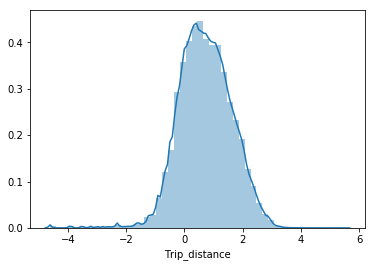

In [352]:
#let's try the log of it and see if it follows a normal distribution
x=np.log(df['Trip_distance'])
sns.distplot(x)

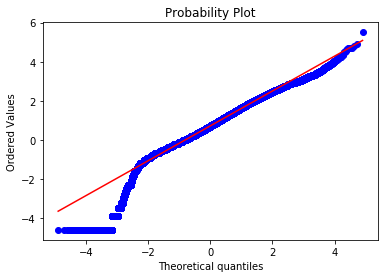

In [353]:
import numpy as np 
import pylab 
import scipy.stats as stats

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(x, dist="norm", plot=pylab)
pylab.show()

Looking at the distribution and qqplot we can say that the log of the data is normal(despite the hump at the begining) this is caused by trip between 0 and 1 miles

## Question 3
the question was alitbit vague when it said report the mean and median trip distance grouped by the hour of the day, it didn't specify the hour of pick up or drop off? since it will give different assumptions, i will assume it's the hour of the pickup

I have a problem stripping the time, i need to have a tuple with the time stripped and then grab the hour index as a new column

In [354]:
df['hour'] = df.lpep_pickup_datetime.apply(lambda x: x[11:-6])#applying lambda functions here which is way better than for loops since it uses parallel processing
df['day']= df.lpep_pickup_datetime.apply(lambda x: x[8:10])
#group by hour of the day and see the stats for trip distance
trip_mean = df['Trip_distance'].groupby(df['hour']).mean()
trip_median = df['Trip_distance'].groupby(df['hour']).median()


Text(0,0.5,'Median Trip Distance In Miles')

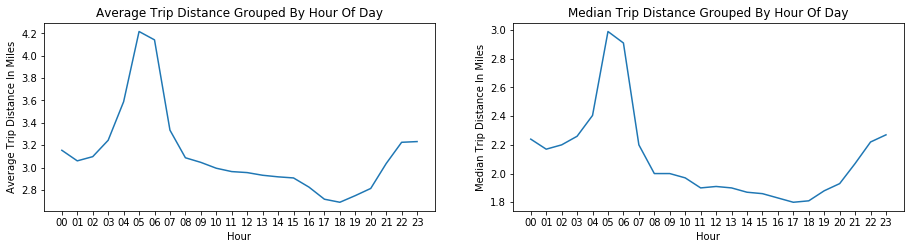

In [355]:
plt.subplots_adjust(left=0.01, right =2, bottom=0, top=1.5, hspace=0.3)

plt.subplot(2,2,1)
plt.plot(trip_mean)
plt.title('Average Trip Distance Grouped By Hour Of Day')
plt.xlabel('Hour')
plt.ylabel('Average Trip Distance In Miles')
plt.subplot(2,2,2)
plt.plot(trip_median)
plt.title('Median Trip Distance Grouped By Hour Of Day')
plt.xlabel('Hour')
plt.ylabel('Median Trip Distance In Miles')

We can see the distibution of the mean and the median is the same(the median is always less than the mean)
We can also see that the Peak is from 5 to 7 am, maybe if we group by the day and see if it was a week day or weekend will give us more explaination about the peak hours

We’d like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fare, and any other interesting characteristics of these trips.

The question is abot vague when it said NYC airports, since there is 3 main airport. what we can do is to take a polygon shape using shapely which does manipulation and analysis of geometric objects in the Cartesian plane.

but in the data dictionary the RatecodeID is the final rate code in effect at the end of the trip. the question was flexible about originating or terminate, so i will subset the data using RatecodeID 2(JFK) and 3(Newwark).

If we didn't have this information we would have to build a polygon of coordinates over each airport and a polygon of coordinates in shapely and over lap the together. 



In [357]:
airport_transaction = df[(df['RateCodeID'] == 2) | (df['RateCodeID'] == 3)]
airport_transaction.head()

VendorID lpep_pickup_datetime Lpep_dropoff_datetime Store_and_fwd_flag  \
902          2  2015-09-01 00:14:55   2015-09-01 00:15:11                  N   
1374         2  2015-09-01 01:08:25   2015-09-01 01:11:01                  N   
1459         2  2015-09-01 01:23:05   2015-09-01 01:23:08                  N   
1684         2  2015-09-01 01:44:02   2015-09-01 01:44:32                  N   
3294         2  2015-09-01 04:43:40   2015-09-01 05:13:33                  N   

      RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
902            2        -73.946716        40.714317         -73.944954   
1374           2        -73.958000        40.721851         -73.956352   
1459           2        -73.830299        40.759933         -73.830505   
1684           2        -73.943886        40.711170         -73.941902   
3294           2        -73.953949        40.803814         -73.782700   

      Dropoff_latitude  Passenger_count ...   MTA_tax  Tip_amount  \
902          40.714466                2 ...       0.5         0.0   
1374         40.721207                2 ...       0.5         0.0   
1459         40.760391                1 ...       0.5         0.0   
1684         40.707485                1 ...       0.5         0.0   
3294         40.644032                1 ...       0.5         0.0   

      Tolls_amount  Ehail_fee  improvement_surcharge  Total_amount  \
902           0.00        NaN                    0.3         52.80   
1374          0.00        NaN                    0.3         52.80   
1459          0.00        NaN                    0.3         52.80   
1684          0.00        NaN                    0.3         52.80   
3294          5.54        NaN                    0.3         58.34   

      Payment_type  Trip_type   hour  day  
902              2         1.0    00   01  
1374             2         1.0    01   01  
1459             2         1.0    01   01  
1684             2         1.0    01   01  
3294             2         1.0    04   01  

[5 rows x 23 columns]

In [358]:
print('Number of transaction that terminate at JFK & Newark is',airport_transaction.shape[0])
print('The average fare of transactions that terminate in JFK & Newark is', airport_transaction['Fare_amount'].mean(), 'USD')

Number of transaction that terminate at JFK & Newark is 4274
The average fare of transactions that terminate in JFK & Newark is 53.24695835283107 USD


Text(0,0.5,'Fare Amount In USD')

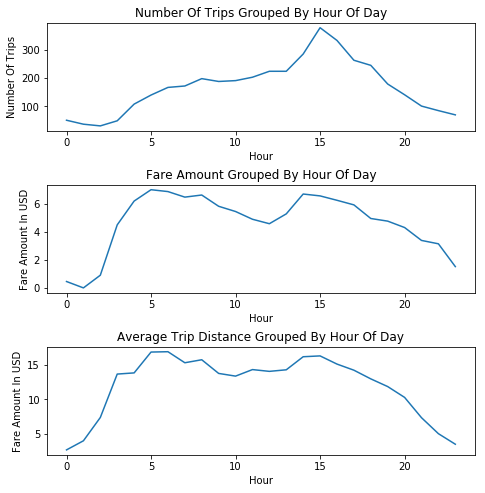

In [322]:
#let's see the number of transactions grouped by the hour
plt.subplots_adjust(left=0.01, right =1, bottom=0, top=1.5, hspace=0.5)

plt.subplot(3,1,1)
plt.plot(airport_transaction['Fare_amount'].groupby(df['hour']).count())
plt.title('Number Of Trips Grouped By Hour Of Day')
plt.xlabel('Hour')
plt.ylabel('Number Of Trips')
plt.subplot(3,1,2)
plt.plot(airport_transaction['Tip_amount'].groupby(df['hour']).mean())
plt.title('Fare Amount Grouped By Hour Of Day')
plt.xlabel('Hour')
plt.ylabel('Fare Amount In USD')
plt.subplot(3,1,3)
plt.plot(airport_transaction['Trip_distance'].groupby(df['hour']).mean())
plt.title('Average Trip Distance Grouped By Hour Of Day')
plt.xlabel('Hour')
plt.ylabel('Fare Amount In USD')

We can see that the peak hour of the day in the airport departures is around 3PM, Also the highest average of trip distance is at 3PM. Also the highest Average fare is at 3PM.

#Question 4
Question 4

•             Build a derived variable for tip as a percentage of the total fare.

•             Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). Provide an estimate of performance using an appropriate sample, and show your work.

adding 
* Tip Percentage from the total fair
* Trip day of the week
* Trip Duration In Minutes
* Trip Speed
* Trip pick up hour
* Trip day of the month
* Trip avergae speed
* Trip Week of the month

In [ ]:
%%time
#this takes around 7 mis to run
#get tip percentage
#calculates the tip percentage from the fare
df['tip_perc'] = (df['Tip_amount']/df['Fare_amount'])*100 

#there are wierdly 400 values on nan after doing this, so i will impute them by the mean
df['tip_perc'] = df.tip_perc.apply(lambda x: df['tip_perc'].mean() if math.isnan(x)==True else x)

#get day of the week
df['day'] = pd.to_numeric(df['day'])

#find which day of the week it is, Mon = 1, Sun = 7
df['day_of_the_week']= df.day.apply(lambda x: datetime.date(2015,9,x).isoweekday())


#get trip duration in minutes
#this is not very readable but essentialy what i am doing is i am taking the difference in time between
#dropoff and pickup and then taking the total seconds of the trip and converting to minutes
df['trip_min'] = ((df.Lpep_dropoff_datetime.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))-df.lpep_pickup_datetime.apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))).apply(lambda y:y.seconds/60.))

#this fixes the trip minute = 1 instead of zero so we can calculate the speed
df['trip_min']=df.trip_min.apply(lambda x: df['trip_min'].median() if x == 0 else x)


#get trip duration in minutes from seconds
df['trip_hr'] = df['trip_min']/60

#change to numeric
df['trip_hr'] = pd.to_numeric(df['trip_hr'])

#assumption is a trip more than 7 hours is data eror and replaced by median!!this takes 5 mins to run by itself!!
df['trip_hr']=df.trip_hr.apply(lambda x: df['trip_hr'].median() if x > 7  else x)

#get the speed of the taxi miles/hr
df['speed'] = df['Trip_distance']/df['trip_hr']

#remove trips with speed > 50 mph, we will consider it as data error(around 4000 observation)
#a better way is to discretize the trip distance and then group by the trip distance and imoute by the median within the 
#given group, but due to time constraint i will just remove them
df = df[df['speed'] < 50]

#this will be used later in question 5
df['week_of_month'] = df.day.apply(lambda x: datetime.date(2015,9,x).isocalendar()[1]-35) #find which week of the mont 1 is week1 2 is week2 ...

#create a new column named time_boundries, i have an intuition the time of the ride is important factor of giving the tip or no
#discretice the pick up time to morning rush, lunch rush, evening rush, and others
#change to numeric
df['hour'] = pd.to_numeric(df['hour'])
mapDict={}
for i in range (0,24):
  if i>4 and i<10: #5 am tp 9 pm
    mapDict[i]="morning rush"
  elif i>10 and i<3: #11am to 2pm
    mapDict[i]="lunch rush"
  elif i>15 and i<20: #4pm to 7pm
    mapDict[i]="evening rush"
  else:
    mapDict[i]="others"
df['timeBoundary']=df['hour'].map(mapDict)
#need to test if this is working
#make new column to indicate if it's a weekday or weekend
map_dict={}
for i in range (1,7):
  if i<6:
    map_dict[i]="week day"
  else:
    mapDict[i]="week end"
df['is_weekday']=df['day_of_the_week'].map(mapDict)
#adds a new column to indicate if the customer tipped or no
df['is_tip'] = df.Tip_amount.apply(lambda x: 0 if x == 0 else 1)



In [394]:
#save work and write to csv
#df.to_csv('data/capital_one_clean.csv')
df=pd.read_csv('data/capital_one_clean.csv')

Text(0,0.5,'Tip Amount')

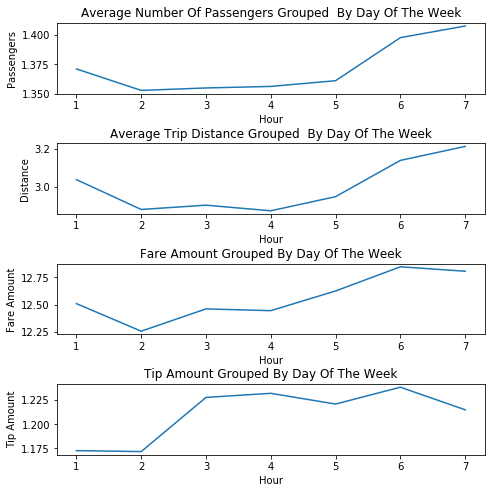

In [395]:
#let's see the number of transactions grouped by the hour
plt.subplots_adjust(left=0.01, right =1, bottom=0, top=1.5, hspace=0.7)


plt.subplot(4,1,1)
plt.plot(df['Passenger_count'].groupby(df['day_of_the_week']).mean())
plt.title('Average Number Of Passengers Grouped  By Day Of The Week')
plt.xlabel('Hour')
plt.ylabel('Passengers')
plt.subplot(4,1,2)
plt.plot(df['Trip_distance'].groupby(df['day_of_the_week']).mean())
plt.title('Average Trip Distance Grouped  By Day Of The Week')
plt.xlabel('Hour')
plt.ylabel('Distance')
plt.subplot(4,1,3)
plt.plot(df['Fare_amount'].groupby(df['day_of_the_week']).mean())
plt.title('Fare Amount Grouped By Day Of The Week')
plt.xlabel('Hour')
plt.ylabel('Fare Amount')
plt.subplot(4,1,4)
plt.plot(df['Tip_amount'].groupby(df['day_of_the_week']).mean())
plt.title('Tip Amount Grouped By Day Of The Week')
plt.xlabel('Hour')
plt.ylabel('Tip Amount')

* From this we can see that the peak of average tip amount is in the weekend
* Also the average number of passengers peaks in the weekend
* Also the Average trip distance peaks in the weekend

In [396]:
#this is the code for getting the zip code from google api but didn't work because google limits the number of calls

#%%time
#for i in range(len(df)):
#  address=[len(df)]
#  location = geolocator.reverse([df['Dropoff_latitude'][i],df['Dropoff_longitude'][i]])
#  if 'postcode' in location.raw['address']:
#    address.append(location.raw['address']['postcode'])
#  else:
#    address.append("NA")
  #df['zip_code'][i] = address[i].raw['address']['postcode']

I was trying to reverse geocode the lat long data using google api but they limit the number of calls, so i decide to  do my spatial analysis in a Geographical Information open source software (QGIS) to gain more insights on the spatial information

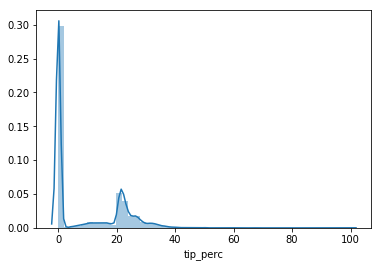

In [397]:
#distribution of the response variable
#let's take the zero's out and check again
sns.distplot(df['tip_perc'])

In [398]:
no_tip = df[df['tip_perc']==0]['tip_perc'].count()
total = df['tip_perc'].count()
print('Number of fares with no tips is',no_tip )
print('Number of total trips is', total)
print('Percentage of trips with no tips is',(100*no_tip)/total,'%' )

Number of fares with no tips is 867003
Number of total trips is 1462858
Percentage of trips with no tips is 59.26774847592863 %


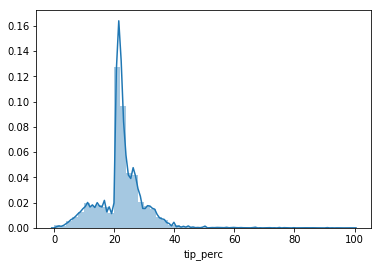

In [399]:
trips_with_tip = df[df['tip_perc'] > 0]
sns.distplot(trips_with_tip['tip_perc'])

Looks way better now, looks like there is a peak around 20% tips, is there a standard tip for taxi's like reseraunts? that would be a good question to investigate?

(array([3.68320e+04, 9.84190e+04, 3.91561e+05, 5.96510e+04, 5.25100e+03,
        2.08300e+03, 9.98000e+02, 5.17000e+02, 3.70000e+02, 1.73000e+02]),
 array([8.33333333e-03, 9.97000000e+00, 1.99316667e+01, 2.98933333e+01,
        3.98550000e+01, 4.98166667e+01, 5.97783333e+01, 6.97400000e+01,
        7.97016667e+01, 8.96633333e+01, 9.96250000e+01]),
 <a list of 10 Patch objects>)

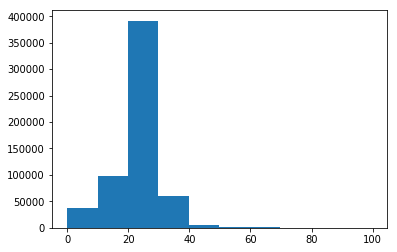

In [400]:
plt.hist(trips_with_tip['tip_perc'])

Now let's do some visualizations to understand more about the data set

(array([1.229008e+06, 1.121690e+05, 3.304100e+04, 9.515000e+03,
        0.000000e+00, 5.721400e+04, 2.189000e+04, 6.000000e+00,
        1.000000e+01, 5.000000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <a list of 10 Patch objects>)

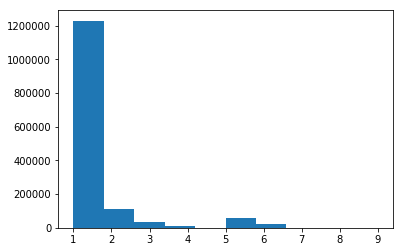

In [401]:
#number of passenger
plt.hist(df['Passenger_count']) #most passenger are 1

In [402]:
df.groupby(['Passenger_count'])['tip_perc'].describe()

count      mean        std  min  25%  50%        75%  \
Passenger_count                                                             
1                1229008.0  9.054606  11.995317  0.0  0.0  0.0  21.333333   
2                 112169.0  9.116483  12.011211  0.0  0.0  0.0  21.388889   
3                  33041.0  9.306009  12.082826  0.0  0.0  0.0  21.400000   
4                   9515.0  8.012042  11.728522  0.0  0.0  0.0  20.814496   
5                  57214.0  8.945793  12.013472  0.0  0.0  0.0  21.384615   
6                  21890.0  9.702677  12.212497  0.0  0.0  0.0  21.600000   
7                      6.0  0.000000   0.000000  0.0  0.0  0.0   0.000000   
8                     10.0  2.583595   6.377029  0.0  0.0  0.0   0.000000   
9                      5.0  4.004004   8.953225  0.0  0.0  0.0   0.000000   

                       max  
Passenger_count             
1                99.625000  
2                96.296296  
3                98.039216  
4                85.714286  
5                95.238095  
6                90.909091  
7                 0.000000  
8                19.953596  
9                20.020020

We can see that 4 passenger has the highest mean and 1 passenger is the dominant class with 83.5% of the data

[Text(0,0.5,'Tip Percentage'),
 Text(0.5,0,'Passenger Count '),
 Text(0.5,1,'Tip Percentage Grouped By Number Of Passengers')]

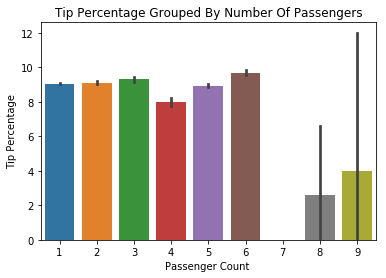

In [403]:
#relation with tip percentage
ax = sns.barplot(x="Passenger_count", y="tip_perc", data=df)
ax.set(xlabel="Passenger Count ",ylabel="Tip Percentage", title='Tip Percentage Grouped By Number Of Passengers')

Let's have a look at the type of payments, looking at the documentation we will be interested in payment 1 (credit card) and 2 (cash). 3 is no charge, 4 is dispute, and 5 is unknown.

We can see a very interesting observation is that only 2 people paid tips in cash and all the other tips are from credit card. and 86% of the people who paid with the card did give a tip.

My guess that the payment type will be an important variable in the model

In [404]:
df.groupby(['Payment_type'])['tip_perc'].describe()

count       mean        std  min        25%        50%  \
Payment_type                                                              
1             689130.0  19.239773  10.486164  0.0  13.793103  21.529412   
2             767919.0   0.000026   0.023102  0.0   0.000000   0.000000   
3               2710.0   0.000000   0.000000  0.0   0.000000   0.000000   
4               3045.0   0.007012   0.386929  0.0   0.000000   0.000000   
5                 54.0   0.000000   0.000000  0.0   0.000000   0.000000   

                    75%        max  
Payment_type                        
1             24.727273  99.625000  
2              0.000000  20.244275  
3              0.000000   0.000000  
4              0.000000  21.351351  
5              0.000000   0.000000

[Text(0,0.5,'Tip Percentage'),
 Text(0.5,0,'Passenger Count '),
 Text(0.5,1,'Tip Percentage Grouped By Number Rate Code ID')]

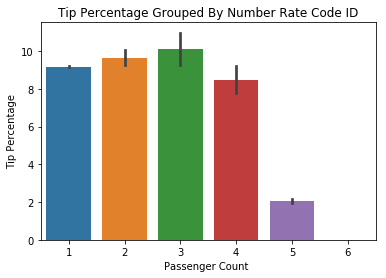

In [405]:
#relation with tip percentage
ax = sns.barplot(x="RateCodeID", y="tip_perc", data=df)
ax.set(xlabel="Passenger Count ",ylabel="Tip Percentage", title='Tip Percentage Grouped By Number Rate Code ID')

In [406]:
df.groupby(['RateCodeID'])['tip_perc'].describe()

count       mean        std  min  25%  50%        75%  \
RateCodeID                                                              
1           1436647.0   9.165918  12.034390  0.0  0.0  0.0  21.391304   
2              3316.0   9.659437  11.523976  0.0  0.0  0.0  22.442308   
3               747.0  10.112334  11.798235  0.0  0.0  0.0  22.705284   
4               881.0   8.493394  11.469309  0.0  0.0  0.0  20.268041   
5             21256.0   2.045990   6.545056  0.0  0.0  0.0   0.000000   
6                11.0   0.000000   0.000000  0.0  0.0  0.0   0.000000   

                  max  
RateCodeID             
1           99.625000  
2           76.923077  
3           58.823529  
4           83.333333  
5           83.333333  
6            0.000000

We can see that rate 1 (standard rate) is the most common in the data set, and also has the highest mean.
rate 2 & 3 (jfk & newark) have almost the same mean

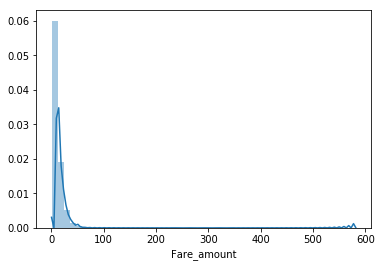

In [407]:
#look at the fare amount distribution
sns.distplot(df['Fare_amount'])

(0, 30)

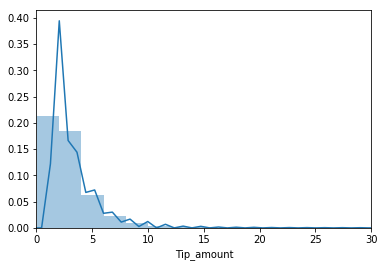

In [408]:
#let's take a closer look of the distribution of the people who paid tips
did_tip = df[df['Tip_amount']>0]
sns.distplot(did_tip['Tip_amount'])
plt.xlim(0,30)
#we can see there is a peak at $3 

## Data Quality Verification

We already did some data cleaning, but we didn't look at the missing values yet, so we eill take a deep dive in the missing values

In [409]:
df.columns

Index(['Unnamed: 0', 'VendorID', 'lpep_pickup_datetime',
       'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'RateCodeID',
       'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude',
       'Dropoff_latitude', 'Passenger_count', 'Trip_distance', 'Fare_amount',
       'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount', 'Ehail_fee',
       'improvement_surcharge', 'Total_amount', 'Payment_type', 'Trip_type ',
       'hour', 'day', 'tip_perc', 'day_of_the_week', 'trip_min', 'trip_hr',
       'speed', 'week_of_month', 'timeBoundary', 'is_weekday', 'is_tip'],
      dtype='object')

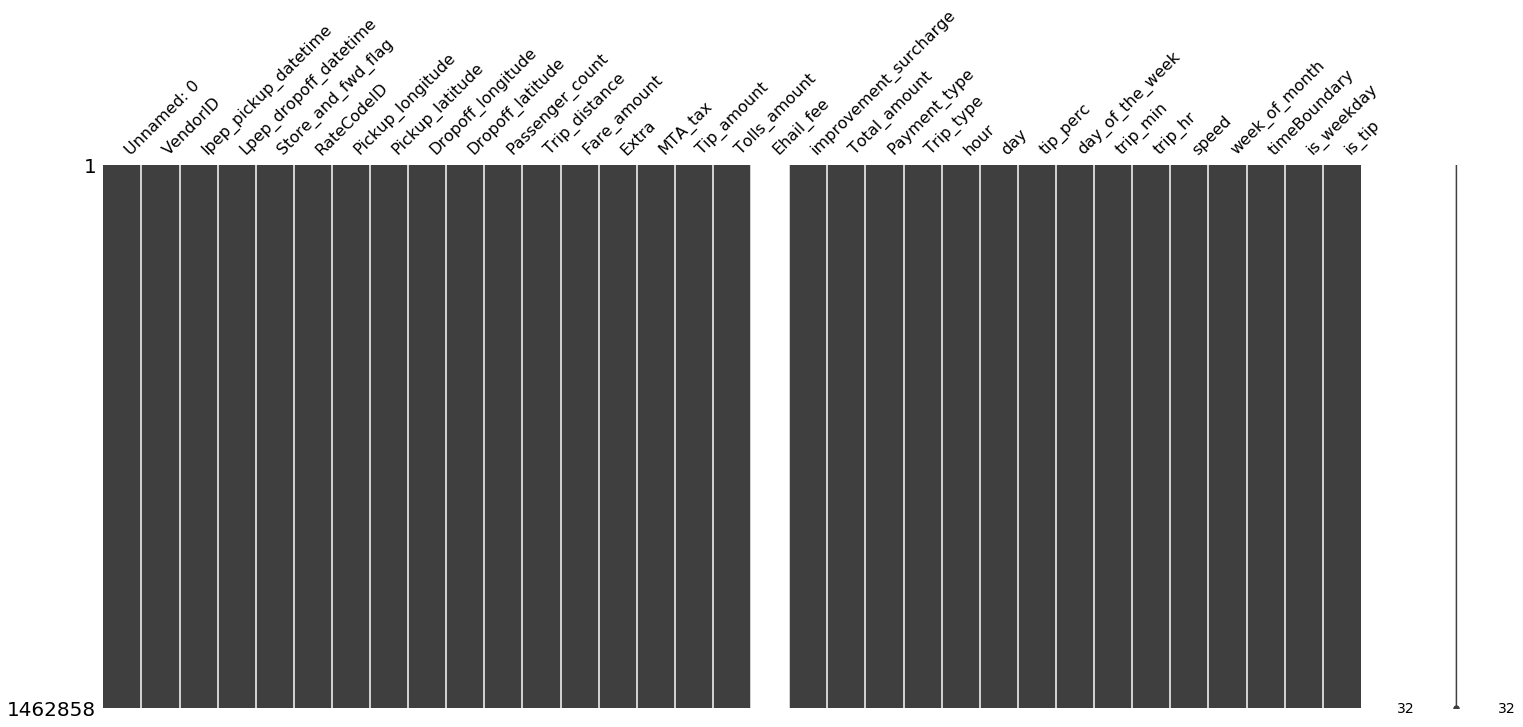

In [410]:
import missingno as mn
mn.matrix(df.sort_values(by=['Trip_distance','RateCodeID']))

In [411]:
print(df.isnull().sum())

Unnamed: 0                     0
VendorID                       0
lpep_pickup_datetime           0
Lpep_dropoff_datetime          0
Store_and_fwd_flag             0
RateCodeID                     0
Pickup_longitude               0
Pickup_latitude                0
Dropoff_longitude              0
Dropoff_latitude               0
Passenger_count                0
Trip_distance                  0
Fare_amount                    0
Extra                          0
MTA_tax                        0
Tip_amount                     0
Tolls_amount                   0
Ehail_fee                1462858
improvement_surcharge          0
Total_amount                   0
Payment_type                   0
Trip_type                      0
hour                           0
day                            0
tip_perc                       0
day_of_the_week                0
trip_min                       0
trip_hr                        0
speed                          0
week_of_month                  0
timeBounda

looks like all the Ehail_fee is missing, so i am going to drop that column

In [412]:
df.drop('Ehail_fee', axis=1, inplace=True)
#df['Trip_type '] = df['Trip_type '].apply(lambda x: df['Trip_type '].mode() if math.isnan(x) == True else x)

# Geospatial Visualization

I utilized QGIS to do the geospatial analysis, i joined the data with NYC census data zip code shape layer available on NYC Open data https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data the shape file contained the zip code boundries as shown in this figure

<img src="data/Visualization/zipcodes.jpg" alt="Zipcode" width="900" height="900" title="Zipcode">

this figure shows the population in NYC, we can see that certain zip codes are highly populated


<img src="data/Visualization/population.jpg" alt="Population" width="900" height="900" title="Population">

I normalize it by the area so we can have better understanding, this figure shows the density of the zip codes

<img src="data/Visualization/density.jpg" alt="Density" width="900" height="900" title="Density">


in this figure we can see a scatter point of the trips pick up locations in New york. We can see that the density of pick up locations is high in Manhattan area
<img src="data/Visualization/s1.jpg" alt="AllPoints" width="900" height="900" title="AllPoints">

and this is the density of trips using a gausian distribution

<img src="data/Visualization/heat_map_of_count.jpg" alt="Counts" width="900" height="900" title="Counts">


In this figure i visualize the fair amount as a graduated color

<img src="data/Visualization/fare_amount.jpg" alt="Fare_Amount" width="900" height="900" title="Fare_Amount">


After that i subseted only the trips that have tips only, you can see the graduated colour of the tip amount in USD, we notice that the tips of the pickups in the suburbs is high, we will see in another plot that these specific trips had long trip distance and most of them the tip percentage was between 18% & 24%.

<img src="data/Visualization/with_tip.jpg" alt="Trip_with_Tip" width="900" height="900" title="Trip_with_Tip">

I subset the data to look at the tips with more than $4 


<img src="data/Visualization/tip_amount.jpg" alt="Tip_Amount" width="900" height="900" title="Tip_Amount">


After that i look at the trip distances and as i said earlier we can see that the suburbs have longer commute and have higher total amount, we found that trying to predict the tip as a percentage of the total amount is a good choice

<img src="data/Visualization/points_by_trip_distance.jpg" alt="Trip_Points" width="900" height="900" title="Trip_Points">


We have a huge problem here, since the response variable is continous and 60% of the data is zero's
If you fit a regression model with least square it would be heavily biased towards 0, as most of our data has tip_perc = 0.

An idea is to try to do a classification problem where we predict that if the passenger is going to pay a tip fare or no

and if the model predicts he is going to tip, we predict what's the tip percentage




#Preparing the variables for modeling
* Drop the Vendor ID because it's nominal variable

* Drop the lpep_pickup_datetime'/pep_dropoff_datetime since we already took the information of them into 4 different columns

* Drop Latitude/Longitude since the model can't use them(i would have loved to have the zip codes)

* Drop the Extra column because 30% of the data is negative and this is supposed to be extra charges

* Drop the MTA_tax since it's a fixed charge that's triggered when the meter turns on

* Drop improvment surcharge since it's afixed rate that just began in 2015, and if we want to use previous years data for training, we won't have this column

* Drop the Tip_amount, since our response variable is derieved from it and this will be cheating on the model

* Drop trip_hour since we already have trip_min




In [413]:
df.columns

Index(['Unnamed: 0', 'VendorID', 'lpep_pickup_datetime',
       'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'RateCodeID',
       'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude',
       'Dropoff_latitude', 'Passenger_count', 'Trip_distance', 'Fare_amount',
       'Extra', 'MTA_tax', 'Tip_amount', 'Tolls_amount',
       'improvement_surcharge', 'Total_amount', 'Payment_type', 'Trip_type ',
       'hour', 'day', 'tip_perc', 'day_of_the_week', 'trip_min', 'trip_hr',
       'speed', 'week_of_month', 'timeBoundary', 'is_weekday', 'is_tip'],
      dtype='object')

In [414]:
df_model = df#.sample(100000)
df_model = df_model.drop(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude', 'Pickup_latitude','Dropoff_longitude', 'Dropoff_latitude',
        'Tip_amount', 'Extra', 'MTA_tax', 'improvement_surcharge', 'Tip_amount', 'trip_hr','Unnamed: 0', 'is_tip'], axis = 1)
#change the column data type
df_model['Passenger_count'] = df_model['Passenger_count'].astype(object)
df_model['Payment_type'] = df_model['Payment_type'].astype(object)
df_model['Trip_type '] = df_model['Trip_type '].astype(object)
df_model['hour'] = df_model['hour'].astype(object)
df_model['day'] = df_model['day'].astype(object)
df_model['day_of_the_week'] = df_model['day_of_the_week'].astype(object)
#one hot encoding
df_model['week_of_month'] = df_model['week_of_month'].astype(object)
df_dummy = pd.get_dummies(df_model, columns=['Passenger_count', 'Payment_type', 'Trip_type ', 'hour', 'day', 'day_of_the_week', 'week_of_month', 'timeBoundary', 'is_weekday'])
#normalize the features
df_normalized = df_dummy
df_normalized['Trip_distance'] = preprocessing.normalize(df_normalized['Trip_distance'].values.reshape(-1,1))
df_normalized['Fare_amount'] = preprocessing.normalize(df_normalized['Fare_amount'].values.reshape(-1,1))
df_normalized['Tolls_amount'] = preprocessing.normalize(df_normalized['Tolls_amount'].values.reshape(-1,1))
df_normalized['trip_min'] = preprocessing.normalize(df_normalized['trip_min'].values.reshape(-1,1))
df_normalized['speed'] = preprocessing.normalize(df_normalized['speed'].values.reshape(-1,1))
y = df_normalized['tip_perc'] #this now has the response variable
df_normalized = df_normalized.drop(['tip_perc'], axis = 1) #this has the features
print(y.shape)
print(df_normalized.shape)

(1462858,)
(1462858, 94)


In [415]:
X_train, X_test, y_train, y_test = train_test_split(df_normalized, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1170286, 94) (1170286,)
(292572, 94) (292572,)


## Build a simple linear regression

In [416]:
# fit a model
lm = linear_model.LinearRegression()
lr_reg = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
lr_reg.score(X_train, y_train)
print('Our simple linear regression model score is:', lr_reg.score(X_train, y_train))
print('Our simple linear regression model score is:', lr_reg.score(X_test, y_test))
print('Our simple linear regression model mse is:', mse(lr_reg.predict(X_test), y_test))
ls = linear_model.Lasso(alpha=0.1)
lasso = ls.fit(X_train,y_train)
print('Our Lasso regression model score is:', lasso.score(X_train, y_train))
print('Our Lasso regression model score is:', lasso.score(X_test, y_test))
print('Our Lasso regression model mse is:', mse(lasso.predict(X_test), y_test))
rid = linear_model.Ridge()
ridge = rid.fit(X_train, y_train)
print('Our Ridge regression model score is:', ridge.score(X_train, y_train))
print('Our Ridge regression model score is:', ridge.score(X_test, y_test))
print('Our Ridge regression model mse is:', mse(ridge.predict(X_test), y_test))
el = linear_model.ElasticNet()
elastic = el.fit(X_train, y_train)
print('Our elastic net regression model score is:', elastic.score(X_train, y_train))
print('Our elastic net regression model score is:', elastic.score(X_test, y_test))
print('Our elASTIC net regression model mse is:', mse(elastic.predict(X_test), y_test))


Our simple linear regression model score is: 0.642370872801697
Our simple linear regression model score is: 0.642226679132055
Our simple linear regression model mse is: 51.37893394900066
Our Lasso regression model score is: 0.6401289703230764
Our Lasso regression model score is: 0.6400024508948334
Our Lasso regression model mse is: 51.698349816596576
Our Ridge regression model score is: 0.642386993814699
Our Ridge regression model score is: 0.6422475281772535
Our Ridge regression model mse is: 51.37593986963902
Our elastic net regression model score is: 0.4422566917119224
Our elastic net regression model score is: 0.4432159738876477
Our elASTIC net regression model mse is: 79.95836478831275


Text(0,0.5,'True Values')

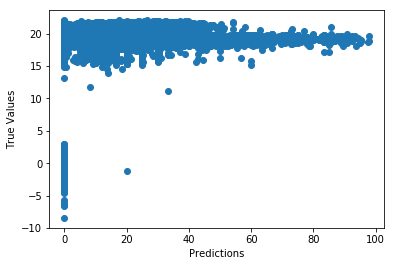

In [417]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('Predictions')
plt.ylabel('True Values')

Our base model is very week.
Let's use sklearn and try different algorithms, we see that Random Forest out performs all the algorithm and after it comes Gradient Boosting

In [418]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.neural_network import MLPRegressor as MLPR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import gradient_boosting as gb
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import mean_squared_error as mse


#mse(LR.fit(X, y).predict(X), y)
mods = [LR(), MLPR(), DTR(), RFR(), GBR()]
[mse(mod.fit(X_train, y_train).predict(X_test), y_test) for mod in mods]

[51.37893394900066,
 49.996855912787055,
 36.19732214257865,
 30.897393129189645,
 43.937509362482714]

In [419]:
[mod.fit(X_train, y_train).score(X_test, y_test) for mod in mods]

[0.642226679132055,
 0.6522155179020839,
 0.747182915961062,
 0.7857362935039209,
 0.694044476460228]

We have the problem of zeros that's making the model bias to the zeros
let's make an ensemble of classifying the trips that are going to tip
and then make a regression model on the trips that are going to tip


In [424]:
#this is adjusted code to make classification
df_model = df
df_model = df_model.drop(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude', 'Pickup_latitude','Dropoff_longitude', 'Dropoff_latitude',
        'Tip_amount', 'Extra', 'MTA_tax', 'improvement_surcharge', 'Tip_amount', 'trip_hr','Unnamed: 0'], axis = 1)
#change the column data type
df_model['Passenger_count'] = df_model['Passenger_count'].astype(object)
df_model['Payment_type'] = df_model['Payment_type'].astype(object)
df_model['Trip_type '] = df_model['Trip_type '].astype(object)
df_model['hour'] = df_model['hour'].astype(object)
df_model['day'] = df_model['day'].astype(object)
df_model['day_of_the_week'] = df_model['day_of_the_week'].astype(object)
#df_model['is_tip'] = df_model['is_tip'].astype(object)
#one hot encoding
df_model['week_of_month'] = df_model['week_of_month'].astype(object)
df_dummy = pd.get_dummies(df_model, columns=['Passenger_count', 'Payment_type', 'Trip_type ', 'hour', 'day', 'day_of_the_week', 'week_of_month', 'timeBoundary', 'is_weekday'])
#normalize the features
df_normalized = df_dummy
df_normalized['Trip_distance'] = preprocessing.normalize(df_normalized['Trip_distance'].values.reshape(-1,1))
df_normalized['Fare_amount'] = preprocessing.normalize(df_normalized['Fare_amount'].values.reshape(-1,1))
df_normalized['Tolls_amount'] = preprocessing.normalize(df_normalized['Tolls_amount'].values.reshape(-1,1))
df_normalized['trip_min'] = preprocessing.normalize(df_normalized['trip_min'].values.reshape(-1,1))
df_normalized['speed'] = preprocessing.normalize(df_normalized['speed'].values.reshape(-1,1))
y = df_model['is_tip'] #this now has the response variable
df_normalized = df_normalized.drop(['tip_perc', 'is_tip'], axis = 1) #this has the features
print(y.shape)
print(df_normalized.shape)

(1462858,)
(1462858, 94)


In [425]:
X_train, X_test, y_train, y_test = train_test_split(df_normalized, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1170286, 94) (1170286,)
(292572, 94) (292572,)


I recently had a project at school of programming the logistic regression from scratch, so i am going to test it out here.
We can see that Sklearn out performs my logestic regression function for a couple of reasons, they use the lib linear solver which solves the optimization problem for the dual while i am using batch gradient descent. that requires way more number of iterations with the right step and it takes way longer as well. but i get almost the same accuracy but way slower.

In [426]:
import numpy as np
import numpy as np
from scipy.special import expit
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
        
blr = BinaryLogisticRegressionBase(0.1)


In [427]:
%%time
# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
 # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)
       
    # public:
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

            
blr = BinaryLogisticRegression(0.1,1500)
blr.fit(X_test, y_test)
print(accuracy_score(y_test,blr.predict(X_test) ))

0.9364395772664507
Wall time: 6min 55s


In [428]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as MLPR
from sklearn.tree import DecisionTreeClassifier as DTR
from sklearn.ensemble import RandomForestClassifier as RFR
from sklearn.ensemble import GradientBoostingClassifier as GBR
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#mse(y,LR.fit(X, y).predict(X))
mods = [LR(), MLPR(), DTR(), RFR(), GBR()]
[accuracy_score(y_test,mod.fit(X_train, y_train).predict(X_test)) for mod in mods]

[0.9371915289227951,
 0.9384561748902834,
 0.9305470106503698,
 0.9260387186743776,
 0.9426363425071436]

Now let's try to make regression on the trips that had tips only

In [429]:
df_tip = df[df['is_tip']==1]
df_model = df_tip#.sample(100000)
df_model = df_model.drop(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude', 'Pickup_latitude','Dropoff_longitude', 'Dropoff_latitude',
        'Tip_amount', 'Extra', 'MTA_tax', 'improvement_surcharge', 'Tip_amount', 'trip_hr','Unnamed: 0', 'is_tip'], axis = 1)
#change the column data type
df_model['Passenger_count'] = df_model['Passenger_count'].astype(object)
df_model['Payment_type'] = df_model['Payment_type'].astype(object)
df_model['Trip_type '] = df_model['Trip_type '].astype(object)
df_model['hour'] = df_model['hour'].astype(object)
df_model['day'] = df_model['day'].astype(object)
df_model['day_of_the_week'] = df_model['day_of_the_week'].astype(object)
#one hot encoding
df_model['week_of_month'] = df_model['week_of_month'].astype(object)
df_dummy = pd.get_dummies(df_model, columns=['Passenger_count', 'Payment_type', 'Trip_type ', 'hour', 'day', 'day_of_the_week', 'week_of_month', 'timeBoundary', 'is_weekday'])
#normalize the features
df_normalized = df_dummy
df_normalized['Trip_distance'] = preprocessing.normalize(df_normalized['Trip_distance'].values.reshape(-1,1))
df_normalized['Fare_amount'] = preprocessing.normalize(df_normalized['Fare_amount'].values.reshape(-1,1))
df_normalized['Tolls_amount'] = preprocessing.normalize(df_normalized['Tolls_amount'].values.reshape(-1,1))
df_normalized['trip_min'] = preprocessing.normalize(df_normalized['trip_min'].values.reshape(-1,1))
df_normalized['speed'] = preprocessing.normalize(df_normalized['speed'].values.reshape(-1,1))
y = df_normalized['tip_perc'] #this now has the response variable
df_normalized = df_normalized.drop(['tip_perc'], axis = 1) #this has the features
print(y.shape)
print(df_normalized.shape)

(595855,)
(595855, 91)


In [430]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.neural_network import MLPRegressor as MLPR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import gradient_boosting as gb
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import mean_squared_error as mse


#mse(LR.fit(X, y).predict(X), y)
mods = [LR(), MLPR(), DTR(), RFR(), GBR()]
[mse(mod.fit(X_train, y_train).predict(X_test), y_test) for mod in mods]

[0.054372840053348886,
 0.05175054230639131,
 0.0502498896860822,
 0.043348080583776524,
 0.04501612171575217]

In [ ]:
[mod.fit(X_train, y_train).score(X_test, y_test) for mod in mods]

In [ ]:
'''
grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)
grid_mse.fit(X_train, y_train)
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))
pred = grid_mse.predict(X_test)
print("Root mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, pred)), 2)))
test = pd.DataFrame({"prediction": pred, "observed": y_test.flatten()})
lowess = sm.nonparametric.lowess
z = lowess(pred.flatten(), y_test.flatten())
test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("Extreme Gradient Boosting: Prediction Vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted Power Output", fontsize = 18) 
plt.ylabel("Observed Power Output", fontsize = 18)
plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)
plt.show()'''

##Question 5

Choose only one of these options to answer for Question 5. There is no preference as to which one you choose. Please select the question that you feel your particular skills and/or expertise are best suited to. If you answer more than one, only the first will be scored.

•             Option A: Distributions

•             Build a derived variable representing the average speed over the course of a trip.

•             Can you perform a test to determine if the average trip speeds are materially the same in all weeks of September? If you decide they are not the same, can you form a hypothesis regarding why they differ?

•             Can you build up a hypothesis of average trip speed as a function of time of day?

•             Option B: Visualization


In [431]:
x = df.groupby(df['week_of_month'])
x[['speed']].mean()


speed
week_of_month           
1              13.450860
2              12.828513
3              12.845935
4              13.322504
5              12.636981

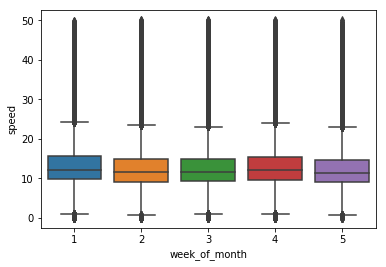

In [432]:
sns.boxplot(x='week_of_month', y='speed', data =df)

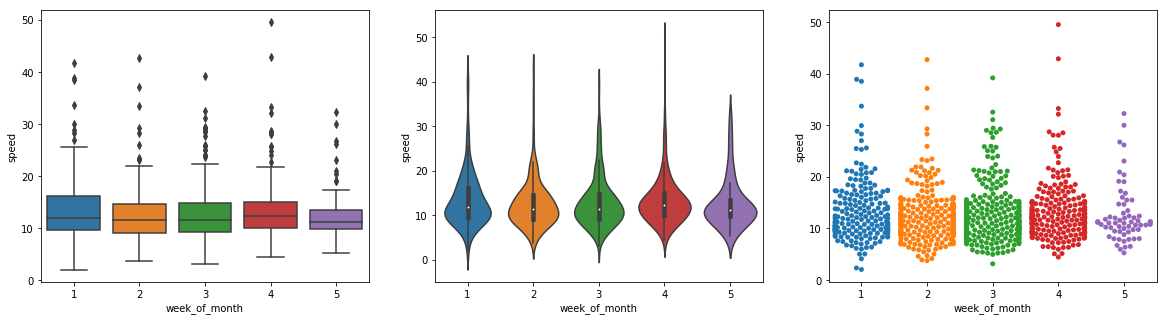

Wall time: 877 ms


In [433]:
%%time
df_vis = df.sample(1000)
plt.subplots(figsize=(20, 5))
args = {'x':"week_of_month", 'y':"speed", 'data':df_vis}
funcs_to_plot = [sns.boxplot,sns.violinplot,sns.swarmplot]
for i, plot_func in enumerate(funcs_to_plot):
    plt.subplot(1,3,i+1)
    plot_func(**args)
    
plt.show()

Here, we take only a sample of the data set since the violin and swarm plot computationally very expensive

In [ ]:
#df.boxplot(column = 'speed',by='week_of_month')

In [435]:
import scipy.stats as stats
week_1 = df['speed'][df['week_of_month'] == 1]
week_2 = df['speed'][df['week_of_month'] == 2]
week_3 = df['speed'][df['week_of_month'] == 3]
week_4 = df['speed'][df['week_of_month'] == 4]
week_5 = df['speed'][df['week_of_month'] == 5]

stats.f_oneway(week_1,week_2, week_3,week_4, week_5)


F_onewayResult(statistic=976.979895854763, pvalue=0.0)

Perform a test to determine if the average trip speeds are materially the same in all weeks of September?
We use one way analysis of variance test to see if there is any difference, and if there is a difference, we do a post hoc analysis using Tukey's test

$Assumptions$：

$Normality$ : ANOVA is robust to this assumptionm  Extremely long-tailed distributions (outliers) or skewed distributions with coupled with different sample sizes (especially when the sample sizes are small) present the only serious distributional problems. In our case we have a big sample size, so no need to worry about normality

$Equal Standard Deviation$: 5 sample have almost the same standard deviation (around 5.8) so we will assume equal standard deviation(can also use histograms for this)

$Independence$: We have no information about how the data was collected, so will assume independence within and across groups


${H_O}$ : $\mu 1$ = $\mu 2$ = $\mu 3$ = $\mu 4$ = $\mu 5$ (equal means model)

${H_a}$: atleast 1 pair $\neq$ (seperate means model)

${F}$ = 976

${Significance Level}$: 95%

${Pvalue}$ = 0

${Decission}$: Reject Null Hypothesis

${Conclusion}$: There is strong evidence at the α=0.05 level of significance $\alpha$ (P = 0 from an ANOVA) to support the claim that the mean speed of groups is not equal

${Note}$: ANOVA test doesn't tell us alot of information, it only tells us that there is atleast 1 of the means of the groups is different. Though this is not required, i will do Tukey's post hoc test. This test compares all possible pairs and we can use it to precisely identify difference between two means that's greater than the expected standard error.

${Tukey's Post Hoc Analysis}$: After doing the test, we have strong evidence to fail to reject the null hypothesis and thus say that week 2 and 3 have the same mean. everything else we fail to reject the null hypothesis which means that the means of the speed over the weeks is statistically different

there might be alot of confounding variable, we would hypothesize that the weather might be a factor of why they differ.

In [ ]:
'''from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
groups = np.array(df['week_of_month'])
values = np.array(df['speed'])
mc = MultiComparison(groups, values)
print(mc.tukeyhsd()[0])'''

In [ ]:
d={}
for i in range (0, 24):
  d["hour_{0}".format(i)] = df['speed'][df['hour'] == i]

stats.f_oneway(hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23)


Build up a hypothesis of average trip speed as a function of time of day. We use one way analysis of variance test to see if there is any difference, and if there is a difference, we do a post hoc analysis using Tukey's test

$Assumptions$：

$Normality$ : ANOVA is robust to this assumptionm  Extremely long-tailed distributions (outliers) or skewed distributions with coupled with different sample sizes (especially when the sample sizes are small) present the only serious distributional problems. In our case we have a big sample size, so no need to worry about normality

$Equal Standard Deviation$: 5 sample have almost the same standard deviation (around 5.8) so we will assume equal standard deviation(can also use histograms for this)

$Independence$: We have no information about how the data was collected, so will assume independence within and across groups


${H_O}$ : $\mu 1$ = $\mu 2$ = $\mu 3$ = $\mu 4$ =  ........ = $\mu n$ (equal means model)(where n = 24)

${H_a}$: atleast 1 pair $\neq$ (seperate means model)

${F}$ = 5264

${Significance Level}$: 95%

${Pvalue}$ = 0

${Decission}$: Reject Null Hypothesis

${Conclusion}$: There is strong evidence at the α=0.05 level of significance $\alpha$ (P = 0 from an ANOVA) to support the claim that the mean speed of groups is not equal

${Note}$: ANOVA test doesn't tell us alot of information, it only tells us that there is atleast 1 of the means of the groups is different. Though this is not required, i will do Tukey's post hoc test. This test compares all possible pairs and we can use it to precisely identify difference between two means that's greater than the expected standard error.

${Tukey's Post Hoc Analysis}$: After doing the test, we have strong evidence to fail to reject the null hypothesis and thus say that the following have the same means.
21-7 / 11-8 / 12-8 / 10-9 / 12-11 / 13-12 / 19-13 / 18-14 / 17-16

everything else we fail to reject the null hypothesis which means that the means of the speed over the weeks is statistically different


In [ ]:
#mc = MultiComparison(df['hour'], df['speed'])
#print(mc.tukeyhsd()[0])